0.9999999999802837


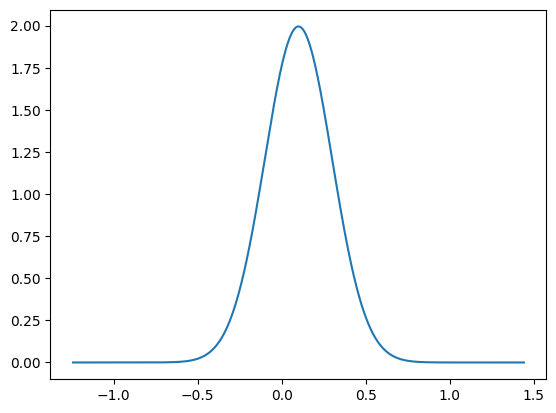

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import tntorch as tn

num_dimensions = 1
mu = 0.10   # Mean vector
cov_matrix = 0.20  # Covariance matrix 

#Discretization parameter

d = 10                 # qubit
m = 2**d               

domain_np = np.linspace(mu - 3*np.sqrt(cov_matrix), mu + 3*np.sqrt(cov_matrix), m)
def gaussian(x):
    return 1/(np.sqrt(2*np.pi)*cov_matrix) * np.exp(-0.5*(((x-mu)/cov_matrix)**2))


vec =  np.array([gaussian(x) for x in domain_np])    # discrete probability vector

dx = domain_np[1] - domain_np[0]
I = np.trapezoid(vec, x = domain_np, dx = dx)
print(I)
plt.plot(domain_np,vec)

In [2]:
shape = (2,)*d         # (2,2,2,2)
A = vec.reshape(shape) #numpy tensor
T=tn.Tensor(A)         #torch tensor

#TENSOR TRAIN
TTrain = tn.cross(
    function=lambda x: x,  
    tensors=[T],            
    ranks_tt=8,                 
)
print(TTrain)

cores_torch = TTrain.cores
cores = [c.cpu().numpy() for c in cores_torch]

print(cores[0].shape)
result = cores[0][0,:,:]

cross device is cpu
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0  | eps: 2.402e-08 | time:   0.0055 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 4.053e-06s (3.346e+08 evals/s)

10D TT tensor:

  2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   8   8   8   8   4   2   1

(1, 2, 2)


In [3]:
import numpy as np

def contract_tt_cores(cores):
    """
    Contraction of the TT cores.
    Input:
      numpy array of shape (r_{k-1}, i_k, r_k)
    Output:
      numpy array of shape (i_1, i_2, ..., i_d)
    """
    result = cores[0]

    for C in cores[1:]:
        result = np.tensordot(result, C, axes=([-1], [0]))
        # we go from (..., i_k, r_k) ⨂ (r_k, i_{k+1}, r_{k+1})
        # to → (..., i_k, i_{k+1}, r_{k+1})
    
    # Now we remove trivial dimension
    return np.squeeze(result)


full_tensor = contract_tt_cores(cores)

print("Reconstructed shape:", full_tensor.shape)
# Should print (2,2,2,2,2,2,2,2,2,2) for d=10

Reconstructed shape: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


1.0000000006600014
381.24959041567683


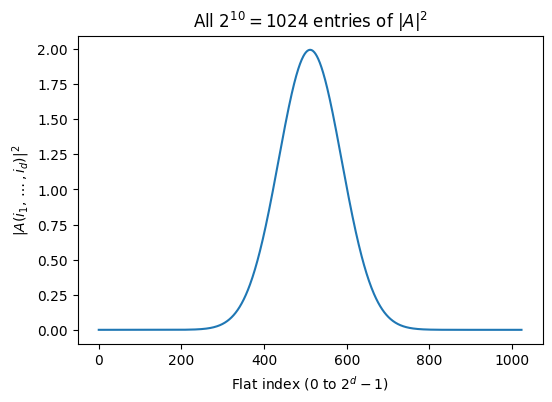

In [4]:
d = full_tensor.ndim  # order of the tensor
N = 2**d

# Flatten and compute |A|^2
values = full_tensor.flatten()                # length 2^d
probs = np.abs(values[:])                # squared magnitudes

I = np.trapezoid(probs, x = domain_np, dx = dx)
print(I)

print(np.sum(probs))
# Plot
plt.figure(figsize=(6,4))
plt.plot(np.arange(N), probs/I)
plt.xlabel('Flat index (0 to $2^d-1$)')
plt.ylabel(r'$|A(i_1,\dots,i_d)|^2$')
plt.title(f'All $2^{{{d}}}={N}$ entries of $|A|^2$')
plt.show()

381.24959015653474


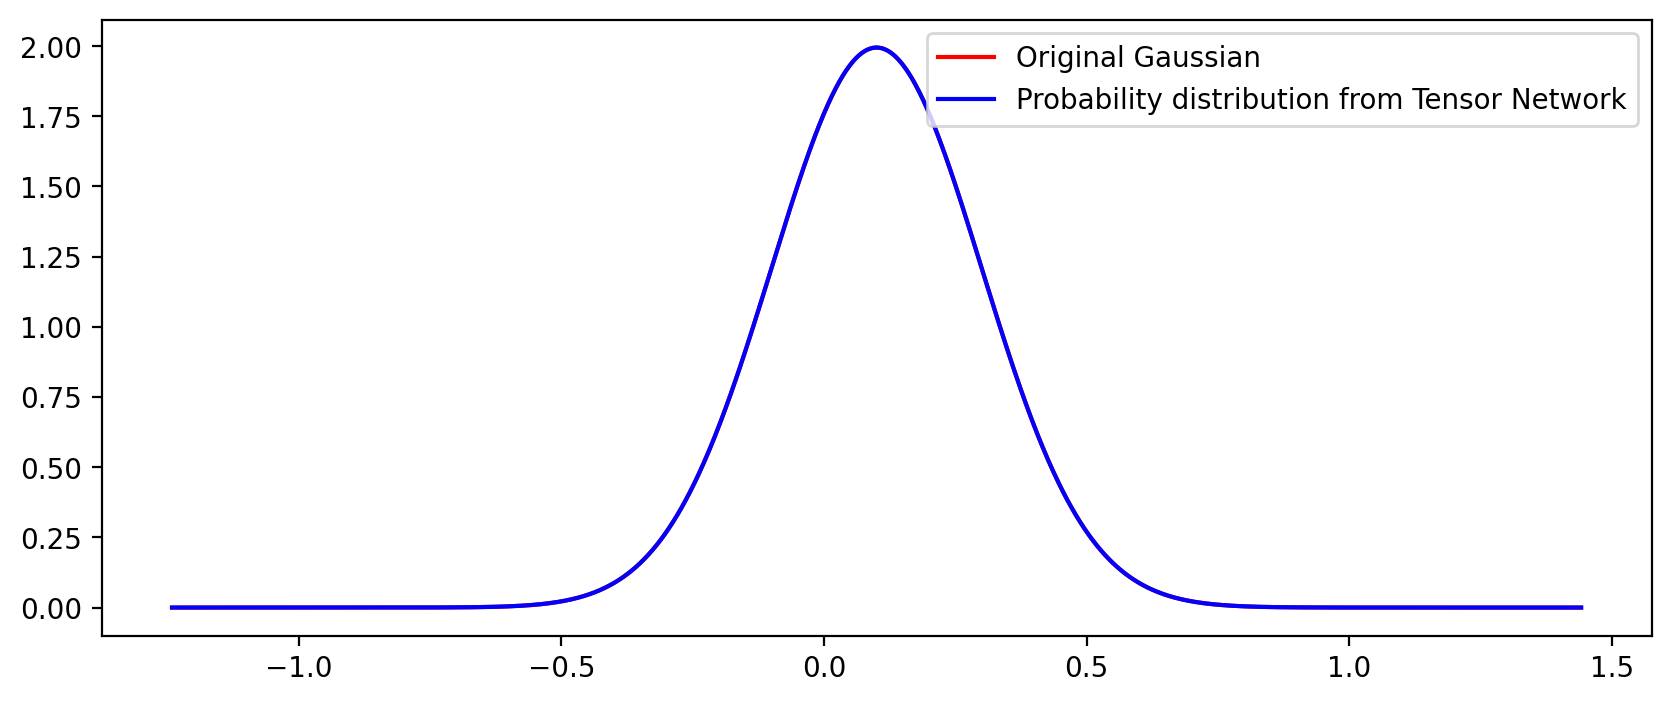

In [5]:
plt.figure(figsize=(10,4),dpi = 200)
print(np.sum(vec))
plt.plot(domain_np,vec,color='r',label='Original Gaussian')
plt.plot(domain_np,probs/I,color='b',label='Probability distribution from Tensor Network')
plt.legend()
#plt.title('Distribuzione di probabilità gaussiana originale')

1.5231519379099723e-09


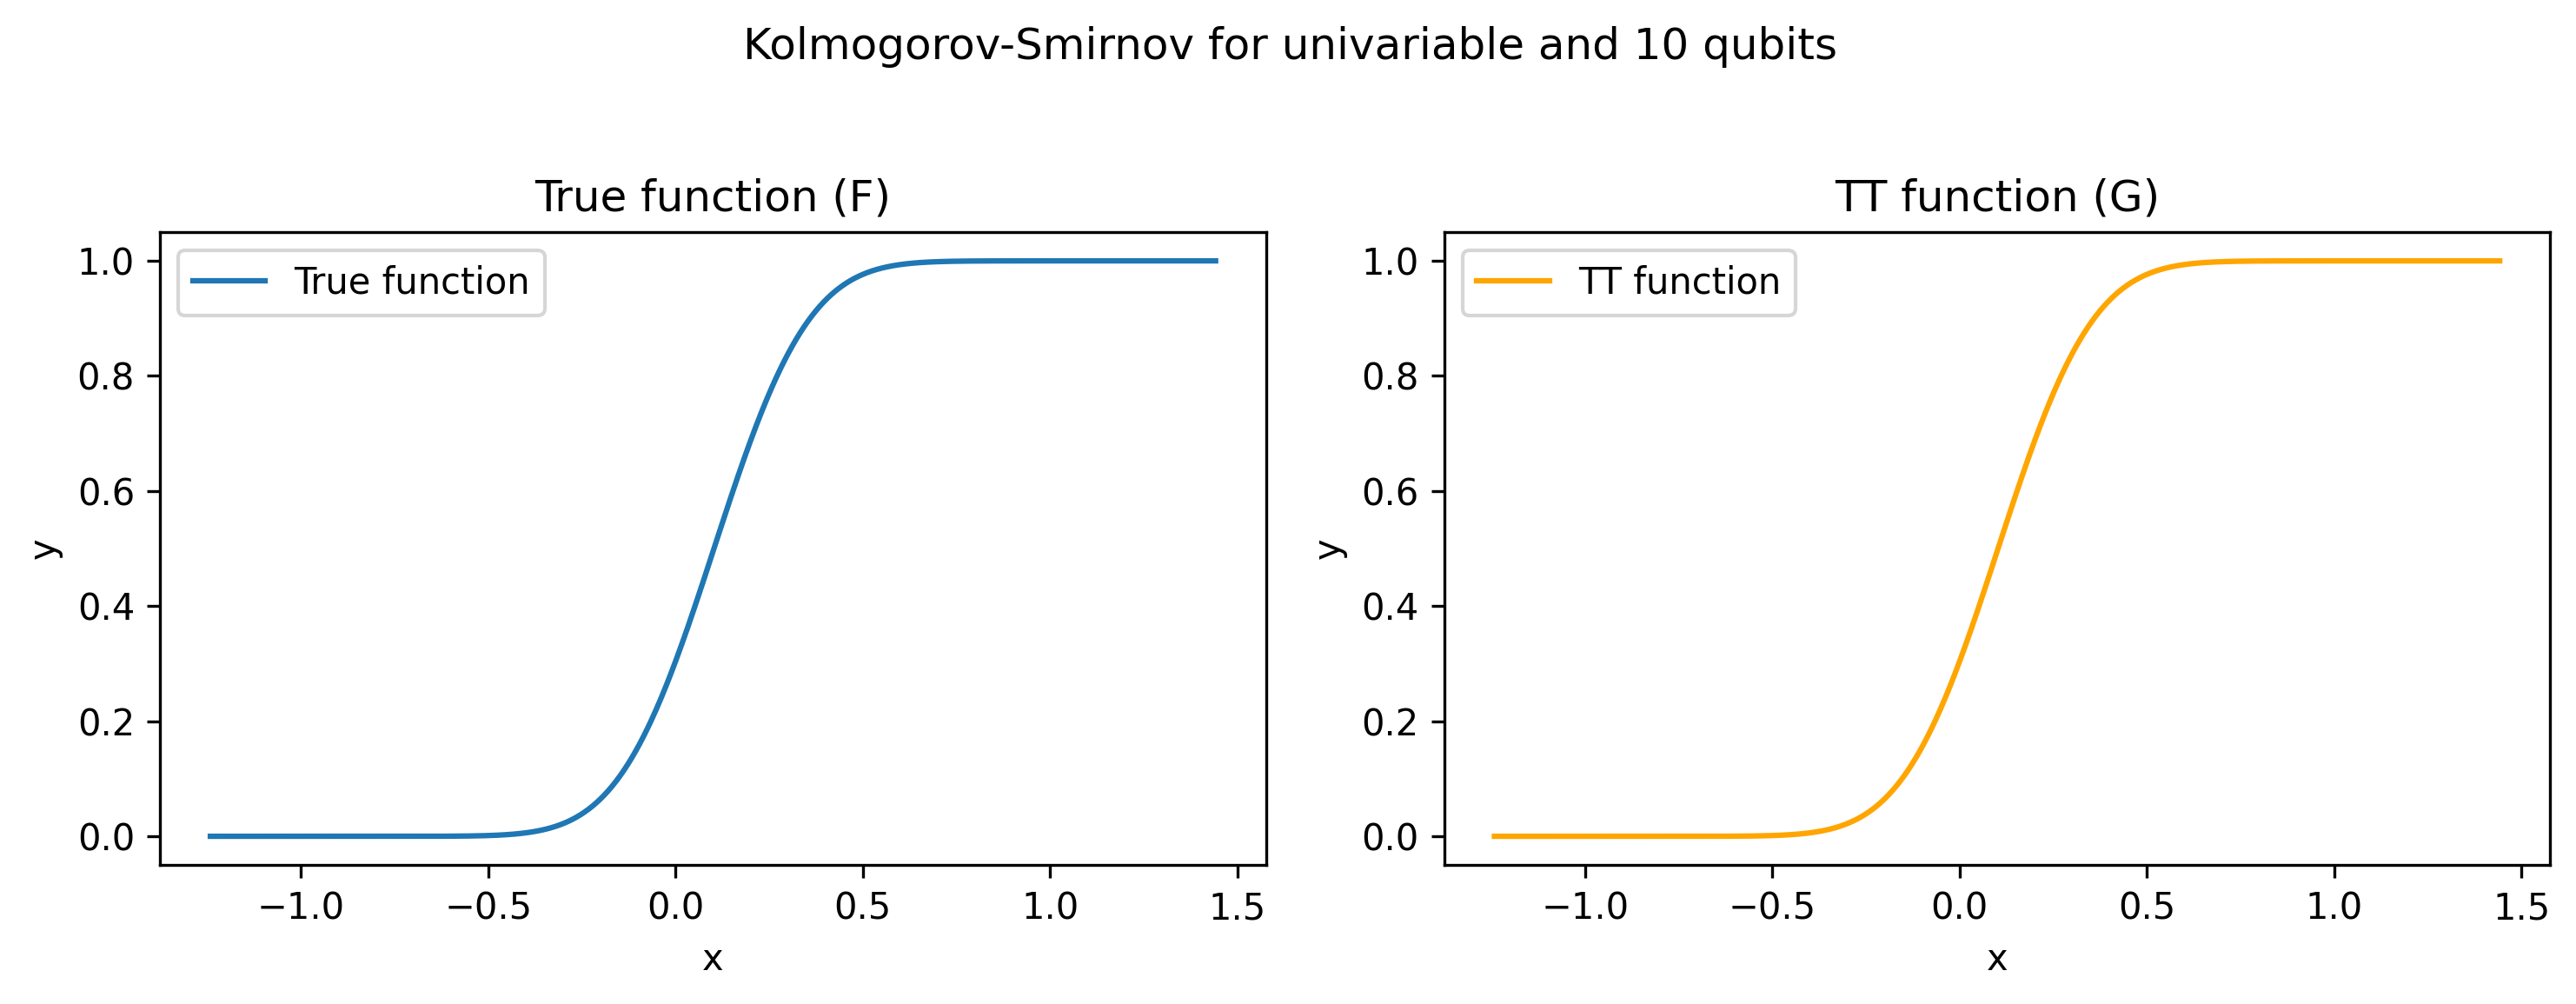

In [6]:
F = np.zeros(len(vec))
G = np.zeros(len(vec))
for x in range(N):
    
    F[x] = np.trapezoid(vec[:x],x = domain_np[:x], dx = dx)
    G[x] = np.trapezoid(probs[:x]/I,x = domain_np[:x], dx = dx)

plt.figure(figsize=(10, 4), dpi=300)  # aumentato larghezza per due subplot

# Primo subplot: True function
plt.subplot(1, 2, 1)
plt.plot(domain_np, F, label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True function (F)')
plt.legend()

# Secondo subplot: TT function
plt.subplot(1, 2, 2)
plt.plot(domain_np, G, label='TT function', color='orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('TT function (G)')
plt.legend()

plt.suptitle('Kolmogorov-Smirnov for univariable and 10 qubits')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # per lasciare spazio al titolo
plt.savefig('KS1_side_by_side.png')

D = np.max(np.abs(F - G))
print(D)